In [1]:
# Import all modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Load dataset
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Training data: {X_train_full.shape}")
print(f"Test data: {X_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
Training data: (50000, 32, 32, 3)
Test data: (10000, 32, 32, 3)


In [3]:
# Split training data (45,000 train + 5,000 validation)
X_train = X_train_full[:45000]
y_train = y_train_full[:45000]
X_valid = X_train_full[45000:]
y_valid = y_train_full[45000:]

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_valid.shape}")
print(f"Test set: {X_test.shape}")

# Normalize to [0, 1]
X_train = X_train.astype('float32') / 255.0
X_valid = X_valid.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print("\n✓ Data normalized")

Training set: (45000, 32, 32, 3)
Validation set: (5000, 32, 32, 3)
Test set: (10000, 32, 32, 3)

✓ Data normalized


In [4]:
# Data augmentation for better accuracy --- Extra
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

datagen.fit(X_train)
print("✓ Data augmentation configured")

✓ Data augmentation configured


In [5]:
# Build optimized CNN model

def create_best_cnn():
    model = models.Sequential([
        # Block 1
        layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(10, activation='softmax')
    ])

    return model

model = create_best_cnn()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,383,626 (12.91 MB)

 Trainable params: 3,380,298 (12.89 MB)

 Non-trainable params: 3,328 (13.00 KB)

In [6]:
# Model Compile
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✓ Model compiled")

✓ Model compiled


In [7]:
# Set Callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_cifar10_cnn.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks = [early_stopping, reduce_lr, checkpoint]

In [8]:
# Train with data augmentation
print("Training started...\n")

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=150,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks,
    verbose=1
)

print("\n Training complete!")


Training started...

Epoch 1/150


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3082 - loss: 2.1699
Epoch 1: val_accuracy improved from -inf to 0.55420, saving model to best_cifar10_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 61s 64ms/step - accuracy: 0.3084 - loss: 2.1694 - val_accuracy: 0.5542 - val_loss: 1.2562 - learning_rate: 0.0010
Epoch 2/150
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5500 - loss: 1.2732
Epoch 2: val_accuracy improved from 0.55420 to 0.67260, saving model to best_cifar10_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.5500 - loss: 1.2731 - val_accuracy: 0.6726 - val_loss: 0.9386 - learning_rate: 0.0010
Epoch 3/150
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6367 - loss: 1.0257
Epoch 3: val_accuracy did not improve from 0.67260
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.6367 - loss: 1.0257 - val_accuracy: 0.5434 - val_loss: 1.5664 - learning_rate: 0.0010
Epoch 4/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6894 - loss: 0.8926
Epoch 4: val_accuracy improved from 0.67260 to 0.77720, saving model to best_cifar10_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.6894 - loss: 0.8925 - val_accuracy: 0.7772 - val_loss: 0.6479 - learning_rate: 0.0010
Epoch 5/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7222 - loss: 0.8001
Epoch 5: val_accuracy did not improve from 0.77720
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.7222 - loss: 0.8001 - val_accuracy: 0.6592 - val_loss: 1.1178 - learning_rate: 0.0010
Epoch 6/150
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7461 - loss: 0.7353
Epoch 6: val_accuracy did not improve from 0.77720
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.7462 - loss: 0.7353 - val_accuracy: 0.7708 - val_loss: 0.6813 - learning_rate: 0.0010
Epoch 7/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7682 - loss: 0.6753
Epoch 7: val_accuracy did not improve from 0.77720
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.7682 - loss: 0.6753 - val_accuracy: 0.7456 - val_loss: 0.7773 - learning_rate: 0.0010
Epoch 8/150

704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.7942 - loss: 0.6009 - val_accuracy: 0.8170 - val_loss: 0.5457 - learning_rate: 0.0010
Epoch 10/150
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8014 - loss: 0.5788
Epoch 10: val_accuracy did not improve from 0.81700
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.8014 - loss: 0.5788 - val_accuracy: 0.7940 - val_loss: 0.6530 - learning_rate: 0.0010
Epoch 11/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8136 - loss: 0.5526
Epoch 11: val_accuracy improved from 0.81700 to 0.81900, saving model to best_cifar10_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.8136 - loss: 0.5526 - val_accuracy: 0.8190 - val_loss: 0.5174 - learning_rate: 0.0010
Epoch 12/150
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8222 - loss: 0.5212
Epoch 12: val_accuracy improved from 0.81900 to 0.83200, saving model to best_cifar10_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.8222 - loss: 0.5212 - val_accuracy: 0.8320 - val_loss: 0.4905 - learning_rate: 0.0010
Epoch 13/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8293 - loss: 0.4994
Epoch 13: val_accuracy improved from 0.83200 to 0.84260, saving model to best_cifar10_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.8293 - loss: 0.4994 - val_accuracy: 0.8426 - val_loss: 0.4619 - learning_rate: 0.0010
Epoch 14/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8323 - loss: 0.4934
Epoch 14: val_accuracy improved from 0.84260 to 0.84560, saving model to best_cifar10_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - accuracy: 0.8323 - loss: 0.4934 - val_accuracy: 0.8456 - val_loss: 0.4697 - learning_rate: 0.0010
Epoch 15/150
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8396 - loss: 0.4693
Epoch 15: val_accuracy improved from 0.84560 to 0.85680, saving model to best_cifar10_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.8396 - loss: 0.4693 - val_accuracy: 0.8568 - val_loss: 0.4159 - learning_rate: 0.0010
Epoch 16/150
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8498 - loss: 0.4409
Epoch 16: val_accuracy improved from 0.85680 to 0.86380, saving model to best_cifar10_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.8498 - loss: 0.4410 - val_accuracy: 0.8638 - val_loss: 0.3961 - learning_rate: 0.0010
Epoch 17/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8505 - loss: 0.4390
Epoch 17: val_accuracy did not improve from 0.86380
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.8505 - loss: 0.4390 - val_accuracy: 0.8246 - val_loss: 0.5281 - learning_rate: 0.0010
Epoch 18/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8559 - loss: 0.4247
Epoch 18: val_accuracy did not improve from 0.86380
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.8559 - loss: 0.4247 - val_accuracy: 0.8516 - val_loss: 0.4503 - learning_rate: 0.0010
Epoch 19/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8618 - loss: 0.4064
Epoch 19: val_accuracy improved from 0.86380 to 0.86820, saving model to best_cifar10_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.8618 - loss: 0.4064 - val_accuracy: 0.8682 - val_loss: 0.3945 - learning_rate: 0.0010
Epoch 20/150
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8641 - loss: 0.3983
Epoch 20: val_accuracy improved from 0.86820 to 0.87120, saving model to best_cifar10_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.8641 - loss: 0.3983 - val_accuracy: 0.8712 - val_loss: 0.3902 - learning_rate: 0.0010
Epoch 21/150
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8656 - loss: 0.3939
Epoch 21: val_accuracy did not improve from 0.87120
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.8656 - loss: 0.3940 - val_accuracy: 0.8296 - val_loss: 0.5171 - learning_rate: 0.0010
Epoch 22/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8683 - loss: 0.3798
Epoch 22: val_accuracy did not improve from 0.87120
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.8683 - loss: 0.3798 - val_accuracy: 0.8486 - val_loss: 0.4659 - learning_rate: 0.0010
Epoch 23/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8741 - loss: 0.3762
Epoch 23: val_accuracy did not improve from 0.87120
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.8741 - loss: 0.3762 - val_accuracy: 0.8612 - val_loss: 0.4282 - learning_rate: 0.0010
Epoch

704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.8886 - loss: 0.3260 - val_accuracy: 0.8892 - val_loss: 0.3382 - learning_rate: 5.0000e-04
Epoch 27/150
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8964 - loss: 0.3039
Epoch 27: val_accuracy improved from 0.88920 to 0.89240, saving model to best_cifar10_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.8964 - loss: 0.3039 - val_accuracy: 0.8924 - val_loss: 0.3334 - learning_rate: 5.0000e-04
Epoch 28/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8979 - loss: 0.2975
Epoch 28: val_accuracy did not improve from 0.89240
704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.8979 - loss: 0.2975 - val_accuracy: 0.8910 - val_loss: 0.3210 - learning_rate: 5.0000e-04
Epoch 29/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9021 - loss: 0.2844
Epoch 29: val_accuracy did not improve from 0.89240
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.9021 - loss: 0.2844 - val_accuracy: 0.8892 - val_loss: 0.3541 - learning_rate: 5.0000e-04
Epoch 30/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9015 - loss: 0.2883
Epoch 30: val_accuracy did not improve from 0.89240
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.9015 - loss: 0.2883 - val_accuracy: 0.8900 - val_loss: 0.3440 - learning_rate: 

704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.9052 - loss: 0.2747 - val_accuracy: 0.8944 - val_loss: 0.3270 - learning_rate: 5.0000e-04
Epoch 33/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9074 - loss: 0.2692
Epoch 33: val_accuracy improved from 0.89440 to 0.89840, saving model to best_cifar10_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.9074 - loss: 0.2692 - val_accuracy: 0.8984 - val_loss: 0.3101 - learning_rate: 5.0000e-04
Epoch 34/150
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9071 - loss: 0.2675
Epoch 34: val_accuracy did not improve from 0.89840
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.9071 - loss: 0.2675 - val_accuracy: 0.8882 - val_loss: 0.3455 - learning_rate: 5.0000e-04
Epoch 35/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9108 - loss: 0.2547
Epoch 35: val_accuracy did not improve from 0.89840
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.9108 - loss: 0.2547 - val_accuracy: 0.8738 - val_loss: 0.3912 - learning_rate: 5.0000e-04
Epoch 36/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9133 - loss: 0.2516
Epoch 36: val_accuracy did not improve from 0.89840
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.9133 - loss: 0.2516 - val_accuracy: 0.8944 - val_loss: 0.3333 - learning_rate: 

704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.9283 - loss: 0.2113 - val_accuracy: 0.9022 - val_loss: 0.3160 - learning_rate: 2.5000e-04
Epoch 43/150
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9270 - loss: 0.2154
Epoch 43: val_accuracy did not improve from 0.90220
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.9270 - loss: 0.2154 - val_accuracy: 0.9022 - val_loss: 0.3073 - learning_rate: 2.5000e-04
Epoch 44/150
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9284 - loss: 0.2073
Epoch 44: val_accuracy improved from 0.90220 to 0.90260, saving model to best_cifar10_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.9284 - loss: 0.2073 - val_accuracy: 0.9026 - val_loss: 0.3136 - learning_rate: 2.5000e-04
Epoch 45/150
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9317 - loss: 0.1986
Epoch 45: val_accuracy did not improve from 0.90260
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.9317 - loss: 0.1986 - val_accuracy: 0.8928 - val_loss: 0.3554 - learning_rate: 2.5000e-04
Epoch 46/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9287 - loss: 0.2090
Epoch 46: val_accuracy improved from 0.90260 to 0.90720, saving model to best_cifar10_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.9287 - loss: 0.2090 - val_accuracy: 0.9072 - val_loss: 0.2988 - learning_rate: 2.5000e-04
Epoch 47/150
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9311 - loss: 0.1991
Epoch 47: val_accuracy did not improve from 0.90720
704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.9311 - loss: 0.1991 - val_accuracy: 0.9046 - val_loss: 0.3042 - learning_rate: 2.5000e-04
Epoch 48/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9328 - loss: 0.1959
Epoch 48: val_accuracy did not improve from 0.90720
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.9328 - loss: 0.1959 - val_accuracy: 0.9016 - val_loss: 0.3023 - learning_rate: 2.5000e-04
Epoch 49/150
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9319 - loss: 0.1997
Epoch 49: val_accuracy did not improve from 0.90720
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.9319 - loss: 0.1997 - val_accuracy: 0.9058 - val_loss: 0.2962 - learning_rate: 

704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.9365 - loss: 0.1853 - val_accuracy: 0.9102 - val_loss: 0.2880 - learning_rate: 2.5000e-04
Epoch 51/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9355 - loss: 0.1895
Epoch 51: val_accuracy improved from 0.91020 to 0.91200, saving model to best_cifar10_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - accuracy: 0.9355 - loss: 0.1895 - val_accuracy: 0.9120 - val_loss: 0.2842 - learning_rate: 2.5000e-04
Epoch 52/150
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9357 - loss: 0.1892
Epoch 52: val_accuracy did not improve from 0.91200
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.9357 - loss: 0.1892 - val_accuracy: 0.9114 - val_loss: 0.2860 - learning_rate: 2.5000e-04
Epoch 53/150
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9388 - loss: 0.1794
Epoch 53: val_accuracy did not improve from 0.91200
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.9388 - loss: 0.1794 - val_accuracy: 0.9102 - val_loss: 0.2914 - learning_rate: 2.5000e-04
Epoch 54/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9364 - loss: 0.1853
Epoch 54: val_accuracy did not improve from 0.91200
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.9364 - loss: 0.1853 - val_accuracy: 0.9048 - val_loss: 0.3220 - learning_rate: 

704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.9459 - loss: 0.1566 - val_accuracy: 0.9126 - val_loss: 0.2914 - learning_rate: 6.2500e-05
Epoch 66/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9445 - loss: 0.1614
Epoch 66: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 66: val_accuracy did not improve from 0.91260
704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.9445 - loss: 0.1614 - val_accuracy: 0.9098 - val_loss: 0.3036 - learning_rate: 6.2500e-05
Epoch 67/150
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9480 - loss: 0.1532
Epoch 67: val_accuracy did not improve from 0.91260
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.9480 - loss: 0.1532 - val_accuracy: 0.9096 - val_loss: 0.3011 - learning_rate: 3.1250e-05
Epoch 68/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9503 - loss: 0.1502
Epoch 68: val_accuracy improved from 0.91260 to 0.91280, saving model to best_cifar10_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.9502 - loss: 0.1502 - val_accuracy: 0.9128 - val_loss: 0.2948 - learning_rate: 3.1250e-05
Epoch 69/150
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9458 - loss: 0.1556
Epoch 69: val_accuracy improved from 0.91280 to 0.91360, saving model to best_cifar10_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.9458 - loss: 0.1556 - val_accuracy: 0.9136 - val_loss: 0.2918 - learning_rate: 3.1250e-05
Epoch 70/150
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9462 - loss: 0.1580
Epoch 70: val_accuracy did not improve from 0.91360
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.9462 - loss: 0.1580 - val_accuracy: 0.9134 - val_loss: 0.2961 - learning_rate: 3.1250e-05
Epoch 71/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9482 - loss: 0.1532
Epoch 71: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 71: val_accuracy did not improve from 0.91360
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - accuracy: 0.9482 - loss: 0.1532 - val_accuracy: 0.9116 - val_loss: 0.2997 - learning_rate: 3.1250e-05
Epoch 72/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9475 - loss: 0.1521
Epoch 72: val_accuracy did not improve from 0.91360
704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.

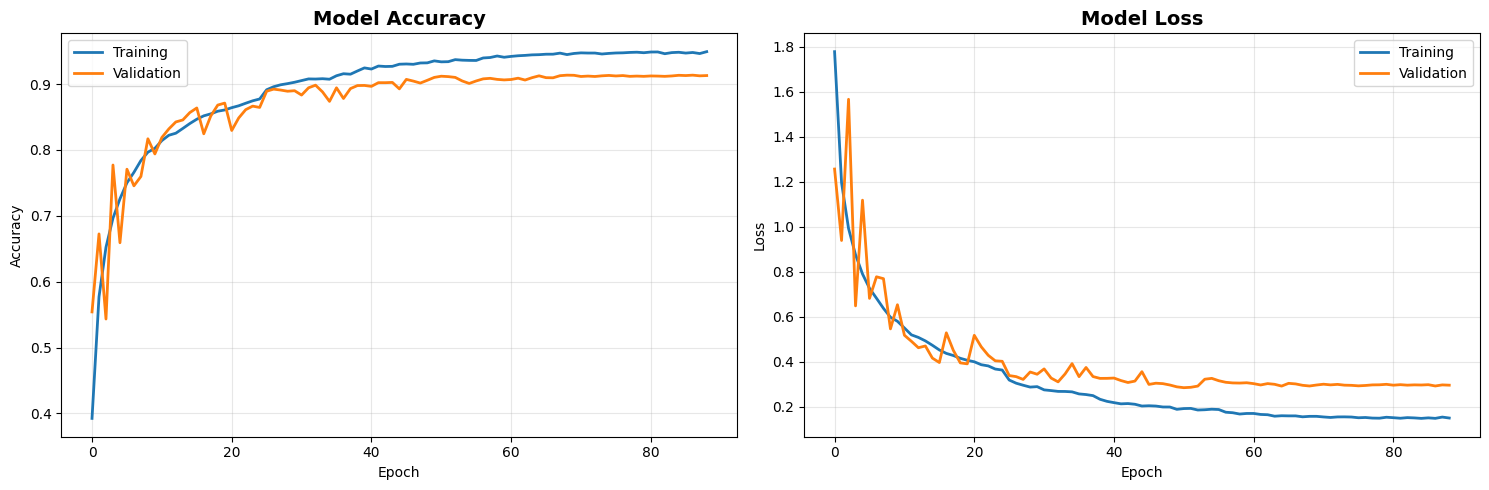

In [9]:
# Visualize training
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Training', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Training', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Validation evaluation
val_loss, val_acc = model.evaluate(X_valid, y_valid, verbose=0)
print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")

y_valid_pred = np.argmax(model.predict(X_valid, verbose=0), axis=1)
y_valid_true = y_valid.flatten()

print("\n" + "="*50)
print("VALIDATION CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_valid_true, y_valid_pred, target_names=class_names))

Validation Accuracy: 0.9136 (91.36%)

VALIDATION CLASSIFICATION REPORT
              precision    recall  f1-score   support

    airplane       0.93      0.92      0.93       493
  automobile       0.95      0.97      0.96       488
        bird       0.91      0.88      0.89       479
         cat       0.84      0.80      0.82       519
        deer       0.92      0.92      0.92       475
         dog       0.92      0.84      0.88       529
        frog       0.85      0.97      0.91       488
       horse       0.93      0.92      0.92       485
        ship       0.96      0.96      0.96       532
       truck       0.93      0.97      0.95       512

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000



In [11]:
# FINAL TEST EVALUATION
print("="*60)
print("FINAL TEST SET EVALUATION")
print("="*60)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print(f"\n TEST ACCURACY: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f" TEST LOSS: {test_loss:.4f}")

# Predictions
y_test_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
y_test_true = y_test.flatten()

# Detailed report
print("\n" + "="*60)
print("TEST SET - CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test_true, y_test_pred, target_names=class_names))

FINAL TEST SET EVALUATION

 TEST ACCURACY: 0.9105 (91.05%)
 TEST LOSS: 0.2992

TEST SET - CLASSIFICATION REPORT
              precision    recall  f1-score   support

    airplane       0.93      0.92      0.93      1000
  automobile       0.93      0.97      0.95      1000
        bird       0.90      0.88      0.89      1000
         cat       0.86      0.78      0.82      1000
        deer       0.91      0.91      0.91      1000
         dog       0.91      0.83      0.87      1000
        frog       0.84      0.97      0.90      1000
       horse       0.94      0.95      0.95      1000
        ship       0.96      0.95      0.95      1000
       truck       0.92      0.95      0.94      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

